# Experimento
Usando directamente los modos normales, sin embargo se presenta el error de asumir que es 0 en los bordes, de manera que a diferencia de PCA no captura correctamente ese fenomeno

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from grav_lens import get_datasets


In [2]:
import os

max_files = 1000
batch_size = 32
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)

Using data folder: ..\data\1
(32, 128, 128, 3)
(32, 128, 128, 1)


# Normal Modes

In [3]:
# tras desarrollar 2_freq_separation.ipynb se crea esta sub libreria temporal
from utils import filtering

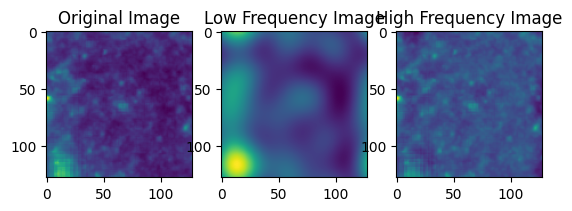

In [11]:
# Procesar una imagen con filtros pasa bajas y pasa altas

image_example = y_batch[0, :, :, 0]
low_freq_image, high_freq_image = filtering.process_image_with_filters(image_example, cutoff=0.05)

# Visualizar las imágenes de baja y alta frecuencia
plt.subplot(1, 3, 1)
plt.imshow(image_example)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(low_freq_image)
plt.title('Low Frequency Image')

plt.subplot(1, 3, 3)
plt.imshow(high_freq_image)
plt.title('High Frequency Image')

plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score


def create_normal_modes(L, m_max, n_max):
    """
    Crea los modos normales en un dominio 2D (L x L).
    
    Args:
    - L: Tamaño del dominio (ej. 128 para imágenes de 128x128)
    - m_max, n_max: Máximo número de nodos en cada dirección (número de modos a calcular)
    
    Returns:
    - modes: Lista de modos normales (funciones sinusoidales)
    """
    x = np.linspace(0, L, L)
    y = np.linspace(0, L, L)
    X, Y = np.meshgrid(x, y)
    
    modes = []
    for m in range(1, m_max + 1):
        for n in range(1, n_max + 1):
            mode = np.sin(m * np.pi * X / L) * np.sin(n * np.pi * Y / L)
            modes.append(mode)
    
    return np.array(modes)

def project_image_on_modes(image, modes):
    """
    Proyecta la imagen sobre los modos normales.
    
    Args:
    - image: Imagen 2D (LxL)
    - modes: Modos normales
    
    Returns:
    - coefficients: Coeficientes de proyección de la imagen en los modos
    """
    coefficients = []
    for mode in modes:
        # Proyección de la imagen en cada modo normal
        coef = np.sum(image * mode)
        coefficients.append(coef)
    return np.array(coefficients)

def reconstruct_image(coefficients, modes):
    """
    Reconstruye la imagen a partir de los coeficientes y modos normales.
    
    Args:
    - coefficients: Coeficientes de proyección
    - modes: Modos normales
    
    Returns:
    - reconstructed_image: Imagen reconstruida
    """
    reconstructed_image = np.zeros_like(modes[0])
    for coef, mode in zip(coefficients, modes):
        reconstructed_image += coef * mode
    return reconstructed_image

def calculate_explained_variance_with_sklearn(image, modes):
    """
    Calcula la varianza explicada a través de la reconstrucción con modos normales
    usando explained_variance_score de sklearn.
    
    Args:
    - image: Imagen 2D original
    - modes: Modos normales
    
    Returns:
    - explained_variance_ratio_cumulative: Varianza explicada acumulada
    """
    # Proyectar la imagen en los modos
    coefficients = project_image_on_modes(image, modes)
    
    explained_variance_ratios = []
    
    for i in range(1, len(modes) + 1):
        # Reconstruir la imagen usando los primeros i modos
        reconstructed_image = reconstruct_image(coefficients[:i], modes[:i])
        
        # Aplanar las imágenes para usar explained_variance_score
        original_flat = image.flatten()
        reconstructed_flat = reconstructed_image.flatten()
        
        # Calcular la varianza explicada usando sklearn
        explained_variance = explained_variance_score(original_flat, reconstructed_flat)
        explained_variance_ratios.append(explained_variance)
    
    return np.array(explained_variance_ratios)



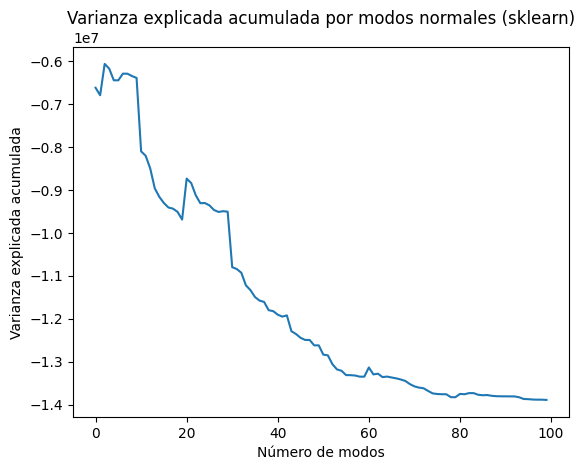

In [39]:
# Crear los modos normales (puedes ajustar el número de modos)
L = 128
m_max = 10
n_max = 10
modes = create_normal_modes(L, m_max, n_max)

# Simulamos una imagen (puedes usar una imagen real en lugar de esto)
image = image_example.numpy()
image = (image - np.min(image)) / (np.max(image) - np.min(image))
# Calcular la varianza explicada acumulada por reconstrucción usando sklearn
explained_variance_by_sklearn = calculate_explained_variance_with_sklearn(image, modes)

# Graficar el resultado
plt.plot(explained_variance_by_sklearn)
plt.xlabel("Número de modos")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada acumulada por modos normales (sklearn)")

plt.show()

In [40]:
# Proyectar la imagen en los modos

coefficients = project_image_on_modes(image, modes)

explained_variance_ratios = []

for i in range(1, len(modes) + 1):
    # Reconstruir la imagen usando los primeros i modos
    reconstructed_image = reconstruct_image(coefficients[:i], modes[:i])
    
    # Aplanar las imágenes para usar explained_variance_score
    original_flat = image.flatten()
    reconstructed_flat = reconstructed_image.flatten()
    
    # Calcular la varianza explicada usando sklearn
    explained_variance = explained_variance_score(original_flat, reconstructed_flat)
    explained_variance_ratios.append(explained_variance)



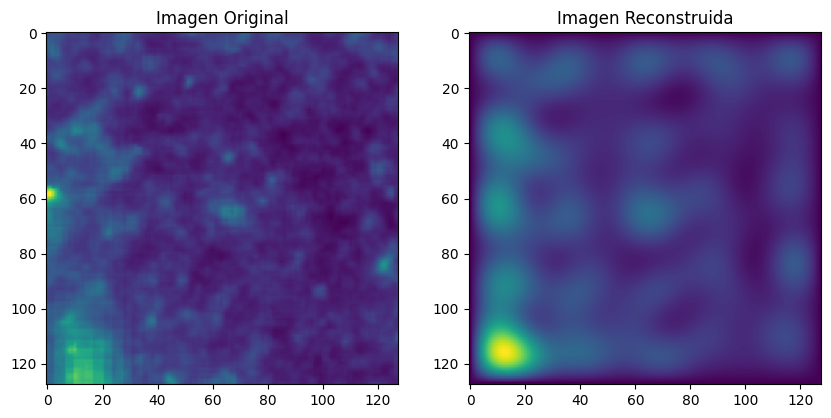

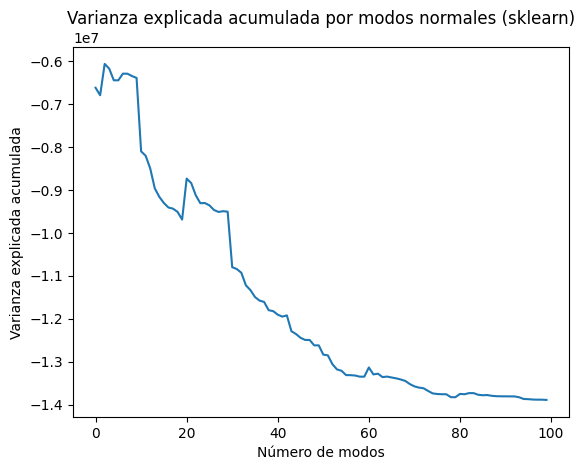

In [41]:
# Graficar las imágenes lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
axes[0].imshow(image, cmap='viridis')
axes[0].set_title("Imagen Original")

# Imagen reconstruida
axes[1].imshow(reconstructed_image, cmap='viridis')
axes[1].set_title("Imagen Reconstruida")

# Mostrar los plots
plt.show()

# Graficar la varianza explicada acumulada
plt.plot(explained_variance_by_sklearn)
plt.xlabel("Número de modos")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada acumulada por modos normales (sklearn)")
plt.show()